# Оглавление
* [Задание](#задание-2)
* [Вступление](#вступление)
* [Получаем данные о городе](#получаем-данные-о-городе)
* [Сохранение в файл](#сохранение-в-файл)
* [Загрузка из файлов](#загрузка-из-файлов)
* [Расчет самых загруженных больниц](#работа-с-данными-расчет-самых-загруженных-больниц)

# Задание 2.
Написать DAG Airflow, тасками которого будут следующие функции (город можно взять любой): 
1. Получение данных обо всех зданиях в городе и геометрии самого города с помощью библиотек osmnx и geopandas, а также сохранение данных в отдельные файлы buildings.geojson, city_geometry.geojson
2. Получение данных о больницах в городе с сохранением в отдельный файл
3. Определение количества домов, которые приходятся на каждую больницу в радиусе 500 метров (тут можно считать расстояние от точки до точки напрямую)
4. Отрисовка графика с самыми загруженными больницами и его сохранение в файл

_____
# Вступление
В этой тетрадке я буду тестировать различные функции и последовательно решать задание, перед тем, как собрать это все в один DAG. 

За город я взяла **Орлеан** во **Франции**. 

In [14]:
# Подключаем нужные библиотеки
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import os

______
## Получаем данные о городе

Получаем **геометрию города**:

In [2]:
city = 'France, Orlean'
city_geometry = ox.geocode_to_gdf(city)
display(city_geometry.head())

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((1.87576 47.89901, 1.87576 47.899, 1....",1.875758,47.81328,1.948711,47.933558,86846510,relation,147559,47.902734,1.908607,boundary,administrative,16,0.662141,city,Orléans,"Orléans, Loiret, Centre-Val de Loire, Metropol..."


Получаем **данные обо всех зданиях** в городе.

In [66]:
buildings_gdf = ox.features_from_place(city, {'building': True})
display(buildings_gdf.head())
display(buildings_gdf.describe())

geometry   building contact:city  \
element id                                                             
node    4428949791     POINT (1.88 47.89886)  dormitory      Orléans   
        6458548716  POINT (1.90296 47.91474)    service          NaN   
        7549263591  POINT (1.89344 47.91504)        yes          NaN   
        7944677540  POINT (1.90978 47.89858)        yes          NaN   
        7944677541  POINT (1.90974 47.89862)        yes          NaN   

                   contact:housenumber      contact:phone contact:postcode  \
element id                                                                   
node    4428949791                   1  +33 3 20 12 25 89            45000   
        6458548716                 NaN                NaN              NaN   
        7549263591                 NaN                NaN              NaN   
        7944677540                 NaN                NaN              NaN   
        7944677541                 NaN                NaN              NaN   

                       contact:street           name  \
element id                                             
node    4428949791  Place De L'europe  Twenty Campus   
        6458548716                NaN            NaN   
        7549263591                NaN            NaN   
        7944677540                NaN            NaN   
        7944677541                NaN            NaN   

                                                  official_name  \
element id                                                        
node    4428949791  Twenty Campus Orléans - Résidence Étudiante   
        6458548716                                          NaN   
        7549263591                                          NaN   
        7944677540                                          NaN   
        7944677541                                          NaN   

                                     opening_hours  ...  \
element id                                          ...   
node    4428949791  Mo-Fr 09:00-12:00, 14:00-18:00  ...   
        6458548716                             NaN  ...   
        7549263591                             NaN  ...   
        7944677540                             NaN  ...   
        7944677541                             NaN  ...   

                   check_date:tactile_paving name:fr building:min_levels  \
element id                                                                 
node    4428949791                       NaN     NaN                 NaN   
        6458548716                       NaN     NaN                 NaN   
        7549263591                       NaN     NaN                 NaN   
        7944677540                       NaN     NaN                 NaN   
        7944677541                       NaN     NaN                 NaN   

                   lockable frequency architect:wikidata house full_name  \
element id                                                                 
node    4428949791      NaN       NaN                NaN   NaN       NaN   
        6458548716      NaN       NaN                NaN   NaN       NaN   
        7549263591      NaN       NaN                NaN   NaN       NaN   
        7944677540      NaN       NaN                NaN   NaN       NaN   
        7944677541      NaN       NaN                NaN   NaN       NaN   

                   live_music currency:EUR  
element id                                  
node    4428949791        NaN          NaN  
        6458548716        NaN          NaN  
        7549263591        NaN          NaN  
        7944677540        NaN          NaN  
        7944677541        NaN          NaN  

[5 rows x 257 columns]

,geometry,building,contact:city,contact:housenumber,contact:phone,contact:postcode,contact:street,name,official_name,opening_hours,...,check_date:tactile_paving,name:fr,building:min_levels,lockable,frequency,architect:wikidata,house,full_name,live_music,currency:EUR
count,33723,33723,16,16,5,16,2,653,5,37,...,1,1,1,1,2,1,15,1,1,1
unique,33723,55,1,12,5,2,2,596,5,32,...,1,1,1,1,1,1,2,1,1,1
top,POINT (1.8972891 47.8843577),yes,Orléans,2,+33 3 20 12 25 89,45000,Place De L'europe,Campo Santo,Twenty Campus Orléans - Résidence Étudiante,24/7,...,2025-03-23,chr orlans,0,yes,50,Q122730688,detached,Institut de Chimie Organique et Analytique,yes,yes
freq,1,28139,16,2,1,14,1,9,1,5,...,1,1,1,1,2,1,12,1,1,1


Получим **данные о больницах** в городе.

In [67]:
hospitals = buildings_gdf[buildings_gdf.building == 'hospital']
display(hospitals.head())
display(hospitals.describe())

geometry  \
element  id                                                            
relation 1592266   POLYGON ((1.89736 47.90092, 1.89778 47.90096, ...   
         7205438   POLYGON ((1.92015 47.83457, 1.92015 47.83464, ...   
         7206143   POLYGON ((1.92288 47.83782, 1.92309 47.83809, ...   
         12716736  POLYGON ((1.92147 47.83614, 1.9214 47.83604, 1...   
         12716738  POLYGON ((1.92225 47.83726, 1.9226 47.83713, 1...   

                   building contact:city contact:housenumber contact:phone  \
element  id                                                                  
relation 1592266   hospital          NaN                 NaN           NaN   
         7205438   hospital          NaN                 NaN           NaN   
         7206143   hospital          NaN                 NaN           NaN   
         12716736  hospital          NaN                 NaN           NaN   
         12716738  hospital          NaN                 NaN           NaN   

                  contact:postcode contact:street                       name  \
element  id                                                                    
relation 1592266               NaN            NaN  Ancien Hôpital Hôtel-Dieu   
         7205438               NaN            NaN                 Point Vert   
         7206143               NaN            NaN                 Point Bleu   
         12716736              NaN            NaN                 Point Rose   
         12716738              NaN            NaN               Point Orange   

                  official_name opening_hours  ... check_date:tactile_paving  \
element  id                                    ...                             
relation 1592266            NaN           NaN  ...                       NaN   
         7205438            NaN           NaN  ...                       NaN   
         7206143            NaN           NaN  ...                       NaN   
         12716736           NaN           NaN  ...                       NaN   
         12716738           NaN           NaN  ...                       NaN   

                  name:fr building:min_levels lockable frequency  \
element  id                                                        
relation 1592266      NaN                 NaN      NaN       NaN   
         7205438      NaN                 NaN      NaN       NaN   
         7206143      NaN                 NaN      NaN       NaN   
         12716736     NaN                 NaN      NaN       NaN   
         12716738     NaN                 NaN      NaN       NaN   

                  architect:wikidata house full_name live_music currency:EUR  
element  id                                                                   
relation 1592266                 NaN   NaN       NaN        NaN          NaN  
         7205438                 NaN   NaN       NaN        NaN          NaN  
         7206143                 NaN   NaN       NaN        NaN          NaN  
         12716736                NaN   NaN       NaN        NaN          NaN  
         12716738                NaN   NaN       NaN        NaN          NaN  

[5 rows x 257 columns]

,geometry,building,contact:city,contact:housenumber,contact:phone,contact:postcode,contact:street,name,official_name,opening_hours,...,check_date:tactile_paving,name:fr,building:min_levels,lockable,frequency,architect:wikidata,house,full_name,live_music,currency:EUR
count,21,21,0,0,0,0,0,12,0,1,...,0,0,0,0,0,0,0,0,0,0
unique,21,1,0,0,0,0,0,12,0,1,...,0,0,0,0,0,0,0,0,0,0
top,"POLYGON ((1.897365 47.900922, 1.8977764 47.900...",hospital,NaN,NaN,NaN,NaN,NaN,Ancien Hôpital Hôtel-Dieu,NaN,24/7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,21,NaN,NaN,NaN,NaN,NaN,1,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____
# Сохранение в файл
**Сохраним** полученные данные в виде файлов формата .geojson

In [ ]:
# Путь к папке для сохранения файлов
OUTPUT_PATH = os.path.join(os.getcwd(), 'output')

city_geometry.to_file(os.path.join(OUTPUT_PATH, 'city_geometry.geojson'))
buildings_gdf.to_file(os.path.join(OUTPUT_PATH, 'buildings.geojson'))
hospitals.to_file(os.path.join(OUTPUT_PATH, 'hospitals.geojson'))

____
# Загрузка из файлов
Попробуем теперь **вытащить** эти данные из файлов и **проверить**, что они **соответствуют изначальным** данным.

In [16]:
city_geometry_copy = gpd.read_file(os.path.join(OUTPUT_PATH, 'city_geometry.geojson'))
display(city_geometry)
display(city_geometry_copy)

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((1.87576 47.89901, 1.87576 47.899, 1....",1.875758,47.81328,1.948711,47.933558,86846510,relation,147559,47.902734,1.908607,boundary,administrative,16,0.662141,city,Orléans,"Orléans, Loiret, Centre-Val de Loire, Metropol..."


,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,geometry
0,1.875758,47.81328,1.948711,47.933558,86846510,relation,147559,47.902734,1.908607,boundary,administrative,16,0.662141,city,Orléans,"Orléans, Loiret, Centre-Val de Loire, Metropol...","POLYGON ((1.87576 47.89901, 1.87576 47.899, 1...."


Столбец `geometry` переместился в конец, но в остальном кажется, что данные остались такими же. Проверим это точнее.

In [ ]:
# Сравним столбцы geometry
city_geometry['geometry'].equals(city_geometry_copy['geometry'])

True

In [ ]:
# Сравним все остальные столбцы кроме столбца geometry

from pandas.testing import assert_frame_equal

df1 = city_geometry.loc[:,'bbox_west':'display_name']
df2 = city_geometry_copy.loc[:,'bbox_west':'display_name']

# display(df1.equals(df2))  # Возвращает False
# assert_frame_equal(df1, df2)  # Возващает ошибку 
    # Attributes of DataFrame.iloc[:, 4] (column name="place_id") are different

    # Attribute "dtype" are different
    # [left]:  int64
    # [right]: int32

# Поменяем все int32 на int64 для этой проверки:
assert_frame_equal(df1, df2.astype({"place_id": 'int64', "osm_id" : 'int64', "place_rank": 'int64'}))  # Ошибок больше не возникает
df1.equals(df2.astype({"place_id": 'int64', "osm_id" : 'int64', "place_rank": 'int64'}))  # Возвращает True

True

Получается, данные идентичны, просто int64 меняется на int32, а столбец `geometry` поменял свое положение. Для нашей задачи это не критично. Теперь сделаем то же самое для двух других файлов.

In [ ]:
hospitals_copy = gpd.read_file(os.path.join(OUTPUT_PATH, 'hospitals.geojson'))
display(hospitals.head())
display(hospitals_copy.head())

geometry  \
element  id                                                            
relation 1592266   POLYGON ((1.89736 47.90092, 1.89778 47.90096, ...   
         7205438   POLYGON ((1.92015 47.83457, 1.92015 47.83464, ...   
         7206143   POLYGON ((1.92288 47.83782, 1.92309 47.83809, ...   
         12716736  POLYGON ((1.92147 47.83614, 1.9214 47.83604, 1...   
         12716738  POLYGON ((1.92225 47.83726, 1.9226 47.83713, 1...   

                   building contact:city contact:housenumber contact:phone  \
element  id                                                                  
relation 1592266   hospital          NaN                 NaN           NaN   
         7205438   hospital          NaN                 NaN           NaN   
         7206143   hospital          NaN                 NaN           NaN   
         12716736  hospital          NaN                 NaN           NaN   
         12716738  hospital          NaN                 NaN           NaN   

                  contact:postcode contact:street                       name  \
element  id                                                                    
relation 1592266               NaN            NaN  Ancien Hôpital Hôtel-Dieu   
         7205438               NaN            NaN                 Point Vert   
         7206143               NaN            NaN                 Point Bleu   
         12716736              NaN            NaN                 Point Rose   
         12716738              NaN            NaN               Point Orange   

                  official_name opening_hours  ... check_date:tactile_paving  \
element  id                                    ...                             
relation 1592266            NaN           NaN  ...                       NaN   
         7205438            NaN           NaN  ...                       NaN   
         7206143            NaN           NaN  ...                       NaN   
         12716736           NaN           NaN  ...                       NaN   
         12716738           NaN           NaN  ...                       NaN   

                  name:fr building:min_levels lockable frequency  \
element  id                                                        
relation 1592266      NaN                 NaN      NaN       NaN   
         7205438      NaN                 NaN      NaN       NaN   
         7206143      NaN                 NaN      NaN       NaN   
         12716736     NaN                 NaN      NaN       NaN   
         12716738     NaN                 NaN      NaN       NaN   

                  architect:wikidata house full_name live_music currency:EUR  
element  id                                                                   
relation 1592266                 NaN   NaN       NaN        NaN          NaN  
         7205438                 NaN   NaN       NaN        NaN          NaN  
         7206143                 NaN   NaN       NaN        NaN          NaN  
         12716736                NaN   NaN       NaN        NaN          NaN  
         12716738                NaN   NaN       NaN        NaN          NaN  

[5 rows x 257 columns]

,element,id,building,contact:city,contact:housenumber,contact:phone,contact:postcode,contact:street,name,official_name,...,name:fr,building:min_levels,lockable,frequency,architect:wikidata,house,full_name,live_music,currency:EUR,geometry
0,relation,1592266,hospital,None,None,None,None,None,Ancien Hôpital Hôtel-Dieu,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((1.89736 47.90092, 1.89778 47.90096, ..."
1,relation,7205438,hospital,None,None,None,None,None,Point Vert,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((1.92015 47.83457, 1.92015 47.83464, ..."
2,relation,7206143,hospital,None,None,None,None,None,Point Bleu,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((1.92288 47.83782, 1.92309 47.83809, ..."
3,relation,12716736,hospital,None,None,None,None,None,Point Rose,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((1.92147 47.83614, 1.9214 47.83604, 1..."
4,relation,12716738,hospital,None,None,None,None,None,Point Orange,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((1.92225 47.83726, 1.9226 47.83713, 1..."


В **оригинальном датафрейме** `hospitals` столбцы `element` и `id` являлись **индексами**. В **датафрейме** `hospitals_copy`, прошедшем через **сохранение в файл**, столбцы `element` и `id` стали обычными столбцами, и добавилась своя **индексация от 0**. Плюс опять столбец `geometry` переместился в конец.

In [51]:
buildings_gdf_copy = gpd.read_file(os.path.join(OUTPUT_PATH, 'buildings.geojson'))
display(buildings_gdf.head())
display(buildings_gdf_copy.head())

geometry   building contact:city  \
element id                                                             
node    4428949791     POINT (1.88 47.89886)  dormitory      Orléans   
        6458548716  POINT (1.90296 47.91474)    service          NaN   
        7549263591  POINT (1.89344 47.91504)        yes          NaN   
        7944677540  POINT (1.90978 47.89858)        yes          NaN   
        7944677541  POINT (1.90974 47.89862)        yes          NaN   

                   contact:housenumber      contact:phone contact:postcode  \
element id                                                                   
node    4428949791                   1  +33 3 20 12 25 89            45000   
        6458548716                 NaN                NaN              NaN   
        7549263591                 NaN                NaN              NaN   
        7944677540                 NaN                NaN              NaN   
        7944677541                 NaN                NaN              NaN   

                       contact:street           name  \
element id                                             
node    4428949791  Place De L'europe  Twenty Campus   
        6458548716                NaN            NaN   
        7549263591                NaN            NaN   
        7944677540                NaN            NaN   
        7944677541                NaN            NaN   

                                                  official_name  \
element id                                                        
node    4428949791  Twenty Campus Orléans - Résidence Étudiante   
        6458548716                                          NaN   
        7549263591                                          NaN   
        7944677540                                          NaN   
        7944677541                                          NaN   

                                     opening_hours  ...  \
element id                                          ...   
node    4428949791  Mo-Fr 09:00-12:00, 14:00-18:00  ...   
        6458548716                             NaN  ...   
        7549263591                             NaN  ...   
        7944677540                             NaN  ...   
        7944677541                             NaN  ...   

                   check_date:tactile_paving name:fr building:min_levels  \
element id                                                                 
node    4428949791                       NaN     NaN                 NaN   
        6458548716                       NaN     NaN                 NaN   
        7549263591                       NaN     NaN                 NaN   
        7944677540                       NaN     NaN                 NaN   
        7944677541                       NaN     NaN                 NaN   

                   lockable frequency architect:wikidata house full_name  \
element id                                                                 
node    4428949791      NaN       NaN                NaN   NaN       NaN   
        6458548716      NaN       NaN                NaN   NaN       NaN   
        7549263591      NaN       NaN                NaN   NaN       NaN   
        7944677540      NaN       NaN                NaN   NaN       NaN   
        7944677541      NaN       NaN                NaN   NaN       NaN   

                   live_music currency:EUR  
element id                                  
node    4428949791        NaN          NaN  
        6458548716        NaN          NaN  
        7549263591        NaN          NaN  
        7944677540        NaN          NaN  
        7944677541        NaN          NaN  

[5 rows x 257 columns]

,element,id,building,contact:city,contact:housenumber,contact:phone,contact:postcode,contact:street,name,official_name,...,name:fr,building:min_levels,lockable,frequency,architect:wikidata,house,full_name,live_music,currency:EUR,geometry
0,node,4428949791,dormitory,Orléans,1,+33 3 20 12 25 89,45000,Place De L'europe,Twenty Campus,Twenty Campus Orléans - Résidence Étudiante,...,None,None,None,None,None,None,None,None,None,POINT (1.88 47.89886)
1,node,6458548716,service,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (1.90296 47.91474)
2,node,7549263591,yes,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (1.89344 47.91504)
3,node,7944677540,yes,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (1.90978 47.89858)
4,node,7944677541,yes,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (1.90974 47.89862)


Аналогично, то же самое, что было с `hospitals`. Это не критично. На соответитвие данным я проверять не буду.

____
# Работа с данными. Расчет самых загруженных больниц
> Задание:
Определение количества домов, которые приходятся на каждую больницу в радиусе 500 метров (тут можно считать расстояние от точки до точки напрямую)

Для следующей работы с данными я буду использовать датафреймы с суффиксом `_copy` (это те, которые были вытащены из файлов), т.к. именно в таком виде они будут использоваться в DAG-е.

In [65]:
# Преобразуем CRS в проекцию, которая сохраняет расстояния
# Мы используем метод to_crs() для преобразования геометрий зданий и больниц в проекцию EPSG:3857 (Web Mercator), 
# это проекция, которая используется в большинстве веб-карт и она подходит для расчетов расстояний.
buildings_gdf_copy1 = buildings_gdf_copy.to_crs(epsg=3857)  # Web Mercator
hospitals_copy1 = hospitals_copy.to_crs(epsg=3857)  # Web Mercator

# Список с количеством зданий для каждой больницы
buildings_per_hospital = []

# Переберем все больницы:
for _, hospital in hospitals_copy1.iterrows():
    # Считаем расстояние до всех зданий
    distances = buildings_gdf_copy1.geometry.distance(hospital.geometry)
    # Считаем количество зданий в радиусе 500 метров
    buildings_count = (distances <= 500).sum()
    # Сохраняем в список
    buildings_per_hospital.append({
        'hospital_id': hospital.id,
        'buildings_count': buildings_count
    })

# Преобразуем список в датафрейм для более красивого отображения
results_df = pd.DataFrame(buildings_per_hospital)
display(results_df)

,hospital_id,buildings_count
0,1592266,1591
1,7205438,265
2,7206143,263
3,12716736,291
4,12716738,272
5,12716739,287
6,12718185,227
7,113997817,1180
8,173259440,99
9,423009118,144


___________
# Черновик
Тут мои попытки использовать рызные функции

In [ ]:
city_graph = ox.graph_from_place('Russia, Dmitrov')
ox.plot.plot_graph(city_graph)

KeyboardInterrupt: 

In [ ]:
gdf = ox.geocoder.geocode_to_gdf("Piedmont, CA, USA")
polygon = ox.utils_geo.buffer_geometry(gdf.iloc[0]["geometry"], 500)
G = ox.graph.graph_from_polygon(polygon, network_type="walk")

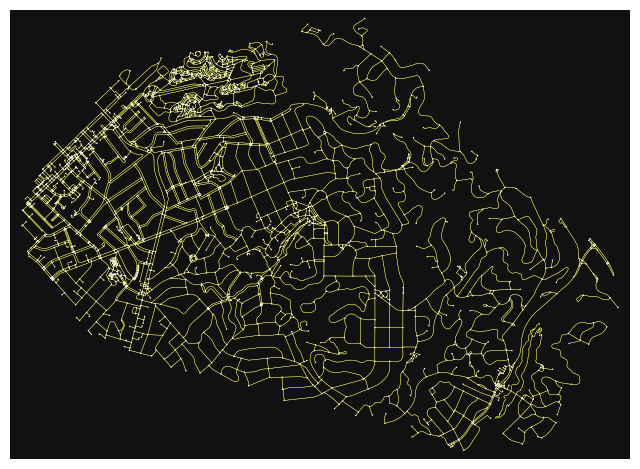

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot.plot_graph(G, node_size=1, edge_color="#FFFF5C", edge_linewidth=0.25)